<a href="https://colab.research.google.com/github/hscrown/madatpublicdata/blob/main/SVD%EB%A5%BC_MLP_NCF%EB%A1%9C_%EA%B5%AC%ED%98%84%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError

In [11]:
#json불러오기
df = pd.read_json('user_rating_1000.json')


# ReLu 사용

In [12]:


# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation='relu')(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation='relu')(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation='relu')(mlp_layer)
mlp_layer = Dense(1)(mlp_layer)  # 평점 예측

# 모델 생성 및 컴파일
model = Model(inputs=[user_input, item_input], outputs=mlp_layer)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 1, 15)                15000     ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 1, 15)                24945     ['input_2[0][0]']             
                                                                                              

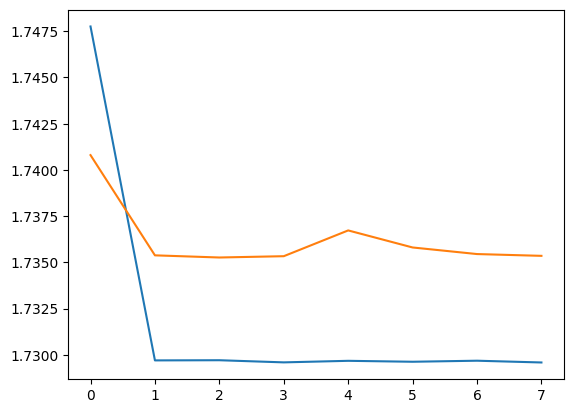

In [20]:
# train loss와 val loss 같이 시각화
# plt.plot(history.history['root_mean_squared_error'])
# plt.plot(history.history['val_root_mean_squared_error'])

# # train mse와 val mse 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

모델이 특정 수준의 성능에 도달한 후 추가적인 학습으로 크게 개선되지 않았음.

# LeakyReLu 사용

In [24]:
from tensorflow.keras.layers import LeakyReLU

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128)(concatenated)
mlp_layer = LeakyReLU(alpha=0.01)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64)(mlp_layer)
mlp_layer = LeakyReLU(alpha=0.01)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32)(mlp_layer)
mlp_layer = LeakyReLU(alpha=0.01)(mlp_layer)
mlp_layer = Dense(1)(mlp_layer)  # 최종 출력은 활성화 함수 없음


# 모델 생성 및 컴파일
model = Model(inputs=[user_input, item_input], outputs=mlp_layer)
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 embedding_6 (Embedding)     (None, 1, 15)                15000     ['input_7[0][0]']             
                                                                                                  
 embedding_7 (Embedding)     (None, 1, 15)                24945     ['input_8[0][0]']             
                                                                                            

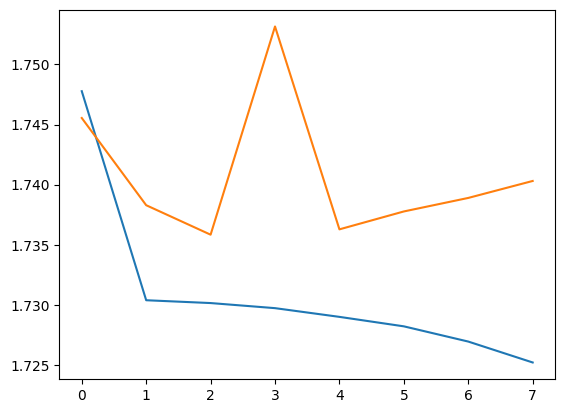

In [26]:
# # train mse와 val mse 시각화
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

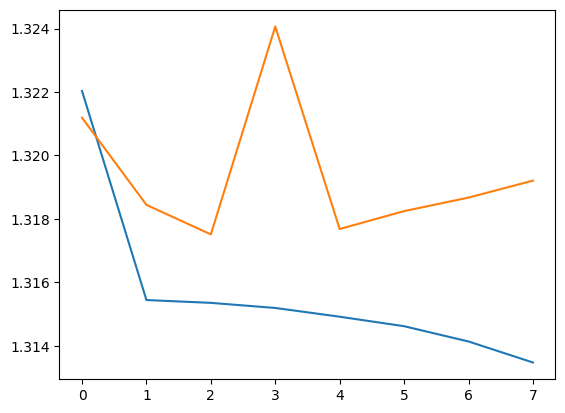

In [25]:
# 시각화
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

ReLu를 LeakyReLu 로 바꿨지만 큰 차이가 없음. ReLu는 음수출력값은 0으로, 양수출력값은 선형으로 바꿔줌.

# 출력층 재설계
평점데이터의 특성을 반영하여 모델의 출력층을 재설계하여 예측 결과를 0.5의 배수로 반올림하도록 수정. 평점의 최고값이 5이고 최저값이 0임을 고려하여 출력층의 활성화 함수와 손실 함수를 조정함

## 출력층에 Sigmoid 함수사용
sigmoid는 값을 0-1사이로 반환하기때문에 원래 음수값이 없는 평점데이터에 더 적합하다고 보았음. 평점이 0.5 단위로 주어지기 때문에 출력층을 재설계해서 예측 결과를 0.5의 배수로 반올림하도록 함.

In [32]:
from tensorflow.keras.layers import Activation

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation='relu')(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation='relu')(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation='relu')(mlp_layer)

# 출력층에 활성화 함수 적용
mlp_output = Dense(1, activation='sigmoid')(mlp_layer)
mlp_output = Activation('sigmoid')(mlp_output)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_18 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_16 (Embedding)    (None, 1, 15)                15000     ['input_17[0][0]']            
                                                                                                  
 embedding_17 (Embedding)    (None, 1, 15)                24945     ['input_18[0][0]']            
                                                                                            

KeyboardInterrupt: 

# 모든 층에 sigmoid 함수 사용
- 출력층에만 sigmoid함수를 사용했더니 오차 값은 커지고 각 에폭마다 학습이 나아지지않는건 똑같아서 학습을 중단시켰다.

In [33]:
from tensorflow.keras.layers import Activation

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation='sigmoid')(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation='sigmoid')(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation='sigmoid')(mlp_layer)

# 출력층에 활성화 함수 적용
mlp_output = Dense(1, activation='sigmoid')(mlp_layer)
mlp_output = Activation('sigmoid')(mlp_output)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_19 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 input_20 (InputLayer)       [(None, 1)]                  0         []                            
                                                                                                  
 embedding_18 (Embedding)    (None, 1, 15)                15000     ['input_19[0][0]']            
                                                                                                  
 embedding_19 (Embedding)    (None, 1, 15)                24945     ['input_20[0][0]']            
                                                                                            

시그모이드 단점:
계산식에 지수 항이 있어서 오래 걸림.(연산비용이 많이든다)

그라디언트 세츄레이션 문제 : 그라디언트는 편미분을 통해 계산되는데 시그모이드 함수 부분에서 미분을 할 경우 함수의 양쪽 끝부분인 -4와 +4 부분을 포함한 구간에서 미분치가 0이 됩니다. 그럴 경우 그라디언트가 0이 되고 학습이 진전이 되지 않아 오차가 더 이상 떨어지지 않게 됩니다.

그라디언트 소실 문제나 폭주 문제를 해결하면서도 출력 범위를 제한할 수 있는 활성화 함수로는 Tanh 함수가 있습니다. Tanh 함수는 Sigmoid 함수와 유사하지만 출력 범위가 -1에서 1 사이로 제한됩니다. 따라서 평점 예측과 같은 출력이 특정 범위에 제한되는 문제에 적합할 수 있습니다.

다른 활성화 함수 중에서도 출력 값을 특정 범위로 제한할 수 있는 함수로는 Swish 함수가 있습니다. Swish 함수는 Sigmoid 함수와 ReLU 함수의 특성을 혼합한 것으로, 다음과 같이 정의됩니다:

Swish
(
𝑥
)
=
𝑥
⋅
Sigmoid
(
𝑥
)
Swish(x)=x⋅Sigmoid(x)
Swish 함수는 ReLU와 유사한 형태를 가지면서도 Sigmoid 함수처럼 출력 값을 0과 1 사이로 압축합니다. 이러한 특성으로 인해 Swish 함수는 신경망의 학습 성능을 향상시킬 수 있는 경우가 있습니다.

Swish 함수는 TensorFlow 2.0부터 기본적으로 제공된다

In [ ]:
# 시각화
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])

# Swish 함수 사용


In [ ]:
from tensorflow.keras.layers import Activation

# Swish 함수 정의
def swish(x):
    return x * tf.sigmoid(x)

# 데이터 전처리
non_zero_df = df[df['rating'] != 0]
pivot_table = non_zero_df.pivot(index='user_id', columns='place_id', values='rating').fillna(0)
train, test = train_test_split(pivot_table, test_size=0.2, random_state=42)

train_users, train_items = np.where(train > 0)
train_ratings = train.values[train > 0]

test_users, test_items = np.where(test > 0)
test_ratings = test.values[test > 0]

# 모델 입력
user_input = Input(shape=(1,), dtype='int32')
item_input = Input(shape=(1,), dtype='int32')

# 임베딩 레이어
user_embedding = Embedding(input_dim=pivot_table.shape[0], output_dim=15, input_length=1)(user_input)
item_embedding = Embedding(input_dim=pivot_table.shape[1], output_dim=15, input_length=1)(item_input)

# 임베딩 벡터 평탄화
user_vector = Flatten()(user_embedding)
item_vector = Flatten()(item_embedding)

# 임베딩 벡터의 연결
concatenated = Concatenate()([user_vector, item_vector])

# MLP 레이어
mlp_layer = Dense(128, activation=swish)(concatenated)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(64, activation=swish)(mlp_layer)
mlp_layer = Dropout(0.2)(mlp_layer)
mlp_layer = Dense(32, activation=swish)(mlp_layer)

# 출력층
mlp_output = Dense(1, activation='sigmoid')(mlp_layer)

# 반올림 함수 정의
def round_to_nearest_half(x):
    return round(x * 2) / 2

# 모델 생성
model = Model(inputs=[user_input, item_input], outputs=mlp_output)

# 손실 함수와 최적화 알고리즘 설정
model.compile(optimizer=Adam(0.001), loss='mean_squared_error', metrics=[RootMeanSquaredError()])

# 모델 요약 출력
model.summary()

# 얼리스타핑 설정
early_stopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=5,
    verbose=1,
    mode='min',
    restore_best_weights=True
)

# 모델 학습
history = model.fit(
    [train_users, train_items], train_ratings,
    validation_data=([test_users, test_items], test_ratings),
    epochs=20,
    verbose=1,
    callbacks=[early_stopping]
)


# Tanh 함수 사용

In [21]:
# 모델 저장
model.save('model0426_2311.h5')

In [15]:
# user_id==11의 평점이 0인데이터, 그린까 아직 평점을 매기지 않은 장소 구하기
unrated_places = pivot_table.loc[11].loc[pivot_table.loc[11] == 0].index
from tensorflow.keras.models import load_model

# 모델 불러오기
model = load_model('model0425_2200.h5')

df2 = df.copy()

# 모델 예측
predictions = model.predict([df2['user_id'], df2['place_id']])

# 예측 평점 출력
print(predictions)

# df2에 'predict_rating' 컬럼추가하기
df2['predict_rating'] = predictions

51969/51969 [==============================] - 100s 2ms/step


KeyboardInterrupt: 

In [ ]:
# user아이디가 11인 사람의 실제 평점과 예측평점
df2[df2['user_id'] == 11].sort_values(by='rating', ascending=False)

In [ ]:
# user아이디가 11인 사람의 예측평점구하기
df2[df2['user_id'] == 11][df2['rating']== 0].sort_values(by='predict_rating', ascending=False).head(10)

In [ ]:
df.info()